In [ ]:
# dependencies. 
## colab version (Uncomment the below line)

!pip install tweet-preprocessor
!pip install lime

##Jupyter notebook version

#import sys
#!{sys.executable} -m pip install tweet-preprocessor 

     |████████████████████████████████| 276kB 4.3MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=bd707e4ba47da8892bb3d45a7b41411b79e653c186e5e217693d7121cbec95ca
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import re, os, csv
import itertools, pickle
import matplotlib.pyplot as plt
#%matplotlib notebook
#from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})

from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from collections import Counter
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
import nltk
import statistics
import preprocessor as p
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Loading the data.
raw_data = pd.read_csv('text_emotion_CLEAN.csv', names=["content", "sentiment"])
raw_data = raw_data.dropna()
cleaned_data = raw_data.reset_index(drop = True)
print(cleaned_data.head(10))

                                             content   sentiment
0  i know i was listenin to bad habit earlier and...       empty
1  layin n bed with a headache ughhhh waitin on y...     sadness
2                     funeral ceremony gloomy friday     sadness
3                wants to hang out with friends soon  enthusiasm
4  we want to trade with someone who has houston ...     neutral
5  re pinging why didn t you go to prom bc my bf ...       worry
6  i should be sleep but im not thinking about an...     sadness
7                                       hmmm is down       worry
8                        charlene my love i miss you     sadness
9                     i m sorry at least it s friday     sadness


In [ ]:
cleaned_data.describe()

,content,sentiment
count,39919,39919
unique,39091,13
top,thanks,neutral
freq,55,8579


In [ ]:
## A FAIRE PLUS PROPRE

##cleaned_data[cleaned_data['sentiment'] in ['sadness', 'neutral', 'worry', 'love', 'hate', 'happiness']]
#cleaned_data.drop(cleaned_data[ cleaned_data['sentiment'] == 'surprise' ].index , inplace=True)
#cleaned_data.drop(cleaned_data[ cleaned_data['sentiment'] == 'fun' ].index , inplace=True)
#cleaned_data.drop(cleaned_data[ cleaned_data['sentiment'] == 'relief' ].index , inplace=True)
cleaned_data.drop(cleaned_data[ cleaned_data['sentiment'] == 'empty' ].index , inplace=True)
#cleaned_data.drop(cleaned_data[ cleaned_data['sentiment'] == 'enthusiasm' ].index , inplace=True)
#cleaned_data.drop(cleaned_data[ cleaned_data['sentiment'] == 'boredom' ].index , inplace=True)
#cleaned_data.drop(cleaned_data[ cleaned_data['sentiment'] == 'anger' ].index , inplace=True)
#cleaned_data.drop(cleaned_data[ cleaned_data['sentiment'] == 'hate' ].index , inplace=True)




# Delete these row indexes from dataFrame

In [ ]:
n_class = len(cleaned_data['sentiment'].unique())
print(n_class)

12


## Resempling datas -> not use because if we resample now the datas, we induces duplicates in the train and test set. So have to resample only train set

In [ ]:
elements = Counter(cleaned_data["sentiment"])
print(elements)
most_freq_emotion = elements.most_common()[0][0]
print(f"apparition of the most freq emotion ({most_freq_emotion}) : {elements[most_freq_emotion]} times")

Counter({'neutral': 8579, 'worry': 8455, 'happiness': 5208, 'sadness': 5162, 'love': 3841, 'surprise': 2186, 'fun': 1776, 'relief': 1526, 'hate': 1323, 'enthusiasm': 759, 'boredom': 179, 'anger': 110})
apparition of the most freq emotion (neutral) : 8579 times


In [ ]:
elements.most_common()

[('neutral', 8579),
 ('worry', 8455),
 ('happiness', 5208),
 ('sadness', 5162),
 ('love', 3841),
 ('surprise', 2186),
 ('fun', 1776),
 ('relief', 1526),
 ('hate', 1323),
 ('enthusiasm', 759),
 ('boredom', 179),
 ('anger', 110)]

In [ ]:
def resample_df(cleaned_data):
    ## count elements in each classes
    elements = Counter(cleaned_data["sentiment"])
    print(elements)

    ## most frequent element
    most_freq_emotion = elements.most_common()[0][0]
    print(f"apparition of the most freq emotion ({most_freq_emotion}) : {elements[most_freq_emotion]} times")

    ## new dataframe
    new_data = pd.DataFrame([], columns=['content', 'sentiment'])
    new_data = pd.concat([new_data, cleaned_data.loc[cleaned_data["sentiment"]==most_freq_emotion]])
    for emotion in elements.keys():
        if emotion!=most_freq_emotion:
            print(f"actual emotion : {emotion}")
            ids = np.array(cleaned_data.loc[cleaned_data["sentiment"]==emotion].index.tolist())
            print(f"index {emotion} :{ids[:5]} ... de longueur {len(ids)} ")
            choices = np.random.choice(ids, elements[max(elements)])
            print(f"new len for {emotion} : {len(choices)}")
            resample_ = cleaned_data.iloc[choices,:]
            #print(resample_)
            new_data =pd.concat([new_data, resample_])
            print('---'*10)
            print(emotion, '--> done')
            print('---'*10)

    ## reindex dataframe        
    new_data.reindex()
    ## explore new count of each sentiments
    new_elements = Counter(new_data["sentiment"])
    print(new_elements)
    return new_data

# ## test of resample_df function
# new_data = resample_df(cleaned_data)
# new_data.head()
# del new_data


In [ ]:
# changing the labels into one hot vectors for training. 
labels = {value: idx for idx, value in enumerate(cleaned_data['sentiment'].unique())}
inv_labels = dict([(v, k) for k,v in labels.items()])
labels

{'anger': 11,
 'boredom': 9,
 'enthusiasm': 1,
 'fun': 6,
 'happiness': 8,
 'hate': 7,
 'love': 5,
 'neutral': 2,
 'relief': 10,
 'sadness': 0,
 'surprise': 4,
 'worry': 3}

In [ ]:
y_data = cleaned_data['sentiment'].apply(lambda x: labels[x]).values
y_data

array([0, 0, 1, ..., 5, 8, 5])

In [ ]:
#cleaning the data. 
cleaned_data['content'] = cleaned_data['content'].map(p.clean)
cleaned_data.head(10)

,content,sentiment
1,layin n bed with a headache ughhhh waitin on y...,sadness
2,funeral ceremony gloomy friday,sadness
3,wants to hang out with friends soon,enthusiasm
4,we want to trade with someone who has houston ...,neutral
5,re pinging why didn t you go to prom bc my bf ...,worry
6,i should be sleep but im not thinking about an...,sadness
7,hmmm is down,worry
8,charlene my love i miss you,sadness
9,i m sorry at least it s friday,sadness
10,cant fall asleep,neutral


In [ ]:
cleaned_data['sentiment'][8]

'sadness'

In [ ]:
## Code to preprocess tweet data.

def preprocess_data(data):
    #Removes Numbers
    data = data.astype(str).str.replace('\d+', '')
    lower_text = data.str.lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer =  TweetTokenizer()

    def lemmatize_text(text):
        return [(lemmatizer.lemmatize(w)) for w \
                        in w_tokenizer.tokenize((text))]
    def remove_punctuation(words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', (word))
            if new_word != '':
                new_words.append(new_word)
        return new_words
    words = lower_text.apply(lemmatize_text)
    words = words.apply(remove_punctuation)
    return pd.DataFrame(words)

In [ ]:
cleaned_data[['content']].head(10)

,content
1,layin n bed with a headache ughhhh waitin on y...
2,funeral ceremony gloomy friday
3,wants to hang out with friends soon
4,we want to trade with someone who has houston ...
5,re pinging why didn t you go to prom bc my bf ...
6,i should be sleep but im not thinking about an...
7,hmmm is down
8,charlene my love i miss you
9,i m sorry at least it s friday
10,cant fall asleep


In [ ]:
pre_tweets = preprocess_data(cleaned_data['content'])
pre_tweets.head()

,content
1,"[layin, n, bed, with, a, headache, ughhhh, wai..."
2,"[funeral, ceremony, gloomy, friday]"
3,"[want, to, hang, out, with, friend, soon]"
4,"[we, want, to, trade, with, someone, who, ha, ..."
5,"[re, pinging, why, didn, t, you, go, to, prom,..."


In [ ]:
## code for removing stop words. 
stop_words = set(stopwords.words('english'))
pre_tweets['content'] = pre_tweets['content'].apply(lambda x: [item for item in \
                                    x if item not in stop_words])

pre_tweets.head()

,content
1,"[layin, n, bed, headache, ughhhh, waitin, call]"
2,"[funeral, ceremony, gloomy, friday]"
3,"[want, hang, friend, soon]"
4,"[want, trade, someone, ha, houston, ticket, one]"
5,"[pinging, go, prom, bc, bf, like, friend]"


In [ ]:
# sentence length data for statistics. 
word_count_list = []
for sentence in pre_tweets['content']:
    word_count_list.append(len(sentence))


In [ ]:
# Tokenising the tweet data.
word_tokenizer = text.Tokenizer()
word_tokenizer.fit_on_texts(pre_tweets['content'])
#word_tokenizer.fit_on_texts(cleaned_data['content'])

In [ ]:
vocab_length = len(word_tokenizer.word_index) + 1
embedded_sentences = word_tokenizer.texts_to_sequences(pre_tweets['content'])

In [ ]:
# stats to decide on the optimal length of the sentence.
median_length = statistics.median(word_count_list)
print("Median length :", median_length)
mean_length = statistics.mean(word_count_list)
print("Mean length :", mean_length)
st_dev = statistics.stdev(word_count_list)
print("Standard déviation :", st_dev)
round(mean_length + 3*st_dev)

Median length : 7.0
Mean length : 7.180646481178396
Standard déviation : 3.964093221383644


19

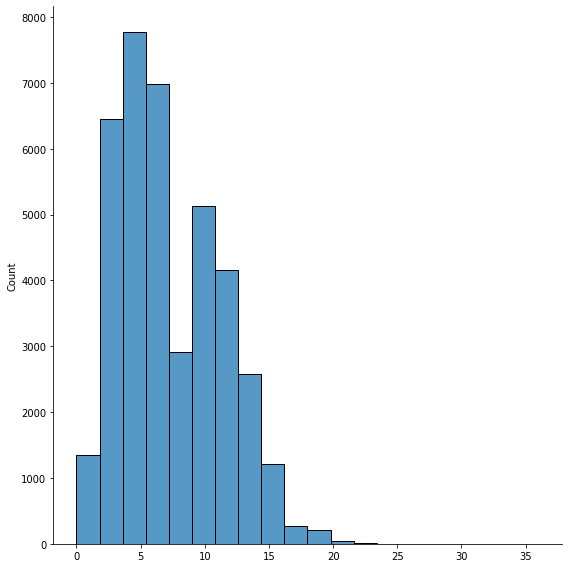

In [ ]:
import seaborn as sns
sns.displot(x=word_count_list, bins=20, height=8, aspect=1)

In [ ]:
# set the sentence length here based on the above stats. 

SENTENCE_LENGTH = round(mean_length + 3*st_dev) #15 # max(cleaned_data['content'].apply(len))
padded_sentences = pad_sequences(embedded_sentences, SENTENCE_LENGTH, padding='post')


In [ ]:
# loading standard Glove vectors
embeddings_dictionary = dict()
glove_src = 'glove.twitter.27B.100d.txt' ## glove.twitter.27B.50d.txt ## glove.twitter.27B.100d.txt ## glove.6B.50d.txt
glove_file = open(glove_src, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [ ]:
# Embedding the words
if '.' in glove_src[-8:-5]:
    embedding_dim = int(glove_src[-7:-5])
    print(f"embedding dim : {embedding_dim}")
else:
    embedding_dim = int(glove_src[-8:-5])
    print(f"embedding dim : {embedding_dim}")
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding dim : 100


In [ ]:
## taux d'éléments du vocabulaire inclus dans la matrice embedding_matrix
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print("freq of current vocab explain in the embedding matrix :", nonzero_elements / vocab_length)

freq of current vocab explain in the embedding matrix : 0.8287655719139297


In [ ]:
# Test - Train split. 
X_train, X_test, y_train, y_test = train_test_split(padded_sentences, y_data, test_size = 0.2, shuffle=True, stratify=y_data)

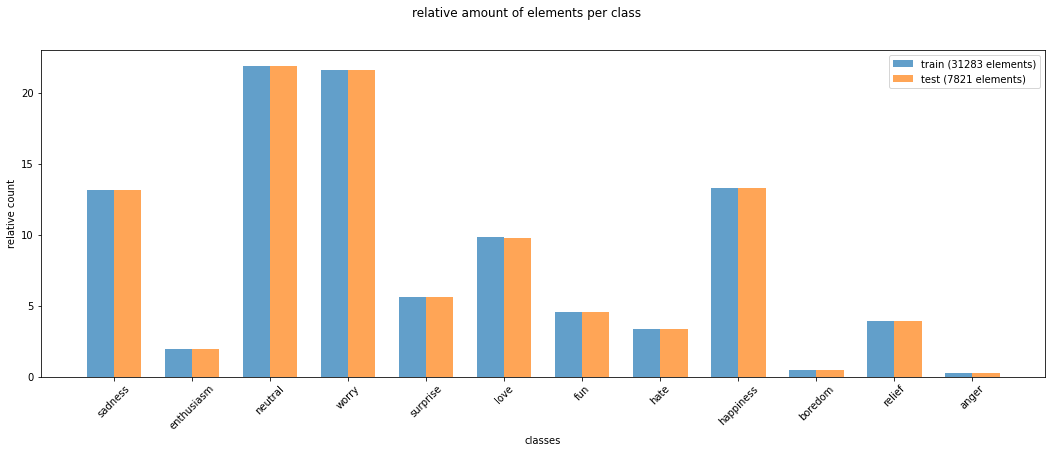

In [ ]:
def plot_hist(y, labels, loc='left'):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
    counts = 100*counts[sorted_index]/y.shape[0]
    
    plt.bar(np.arange(len(unique)) +n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(np.arange(len(unique)), labels, rotation=45) ## unique in place of labels
    plt.xlabel('classes')
    plt.ylabel('relative count')

plt.figure(figsize=(18,6))
plt.suptitle('relative amount of elements per class')
plot_hist(y_train, labels, loc='left')
plot_hist(y_test, labels, loc='right')
plt.legend([
    'train ({0} elements)'.format(len(y_train)), 
    'test ({0} elements)'.format(len(y_test))
]);

**Chaques émotion est équitablement répartie entre le train et le test mais la répartition n'est vraiment pas homogène entre les classes.**

## Resample X_train and y_train

In [ ]:
labels

{'anger': 11,
 'boredom': 9,
 'enthusiasm': 1,
 'fun': 6,
 'happiness': 8,
 'hate': 7,
 'love': 5,
 'neutral': 2,
 'relief': 10,
 'sadness': 0,
 'surprise': 4,
 'worry': 3}

In [ ]:
def find_key(dic, value):
    key = [k  for (k, val) in dic.items() if val == value]
    return key[0]

## test
emot = find_key(labels, 3)
print(emot)

worry


In [ ]:
Counter(y_data)

Counter({0: 5162,
         1: 759,
         2: 8579,
         3: 8455,
         4: 2186,
         5: 3841,
         6: 1776,
         7: 1323,
         8: 5208,
         9: 179,
         10: 1526,
         11: 110})

In [ ]:
# include_emotions = ['anger', 'boredom', 'enthusiasm', 'empty']
# include = [labels[i] for i in include_emotions]
# print(include)
def resample_array(X, y, labels, include=[i for i in range(13)], length=0):
    elements = Counter(y)
    print(elements)
    print(elements.most_common()[0][0])

    ## most frequent element
    most_freq_emotion = find_key(labels, elements.most_common()[0][0])
    print(f"apparition of the most freq emotion ({most_freq_emotion}) : {elements[labels[most_freq_emotion]]} times")

    res_y = y[y==labels[most_freq_emotion]]
    print(f"shape resample y_train after add {most_freq_emotion}", res_y.shape)
    res_X = X[y==labels[most_freq_emotion]]
    print(f"shape resample X_train after add {most_freq_emotion}", res_X.shape)

    for emotion_int in elements.keys():
        if (emotion_int!=labels[most_freq_emotion]) and (emotion_int in include):
            print(f"actual emotion : {find_key(labels, emotion_int)}")
            ids = np.where(y==emotion_int)[0]# y.values==emotion_int
            print(f"index {emotion_int} :{ids[:5]} ... de longueur {len(ids)} ")
            if length == 0:
                length = elements[labels[most_freq_emotion]]
            choices = np.random.choice(ids, size=length)
            #print(choices)
            print(f"new len for {find_key(labels, emotion_int)} : {len(choices)}")
            resample_y_ = y[choices]#y.iloc[choices]
            resample_X_ = X[choices]
            print(resample_X_.shape)
            print("temp resample y shape :", resample_y_.shape, "temp resample X shape :", resample_X_.shape)
            res_y = np.concatenate([res_y, resample_y_], axis=0)
            res_X = np.concatenate([res_X, resample_X_], axis=0)
            print('---'*10)
            print(find_key(labels, emotion_int), '--> done')
            print('---'*10)

        elif (emotion_int!=labels[most_freq_emotion]) and (emotion_int not in include):
            resample_y_ = y[y==emotion_int]
            resample_X_ = X[y==emotion_int]
            res_y = np.concatenate([res_y, resample_y_], axis=0)
            res_X = np.concatenate([res_X, resample_X_], axis=0)
            print('---'*10)
            print(find_key(labels, emotion_int), '--> done')
            print('---'*10)
            

    order = np.arange(len(res_y))
    np.random.shuffle(order)
    res_X = res_X[order]
    res_y = res_y[order]
    return res_X, res_y

res_X_train, res_y_train = resample_array(X_train, y_train, labels)#, include, length=1000)  
print("shape of the resample matrix X_train :", res_X_train.shape)

res_X_test, res_y_test = resample_array(X_test, y_test, labels)#, include, length=250)  
print("shape of the resample matrix X_train :", res_X_test.shape)

Counter({2: 6863, 3: 6764, 8: 4166, 0: 4130, 5: 3073, 4: 1749, 6: 1421, 10: 1221, 7: 1058, 1: 607, 9: 143, 11: 88})
2
apparition of the most freq emotion (neutral) : 6863 times
shape resample y_train after add neutral (6863,)
shape resample X_train after add neutral (6863, 19)
actual emotion : surprise
index 4 :[ 1  5 29 52 55] ... de longueur 1749 
new len for surprise : 6863
(6863, 19)
temp resample y shape : (6863,) temp resample X shape : (6863, 19)
------------------------------
surprise --> done
------------------------------
actual emotion : happiness
index 8 :[ 2 20 36 38 48] ... de longueur 4166 
new len for happiness : 6863
(6863, 19)
temp resample y shape : (6863,) temp resample X shape : (6863, 19)
------------------------------
happiness --> done
------------------------------
actual emotion : sadness
index 0 :[ 4 18 19 22 25] ... de longueur 4130 
new len for sadness : 6863
(6863, 19)
temp resample y shape : (6863,) temp resample X shape : (6863, 19)
---------------------

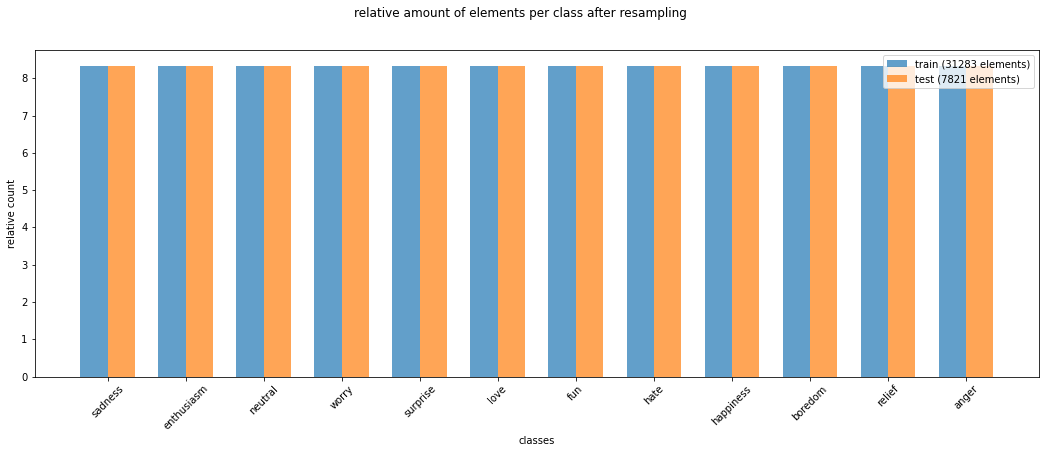

In [ ]:
plt.figure(figsize=(18,6))
plt.suptitle('relative amount of elements per class after resampling')
plot_hist(res_y_train, labels, loc='left')
plot_hist(res_y_test, labels, loc='right')
plt.legend([
    'train ({0} elements)'.format(len(y_train)), 
    'test ({0} elements)'.format(len(y_test))
]);

In [ ]:
# Attention layer Implementation. 

class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)


In [ ]:
from keras.backend import clear_session
clear_session()


def create_model_BiLSTM(vocab_length, embedding_matrix, SENTENCE_LENGTH, trainable=True, drop_percent = 0.3):
    
    # Define the model for learning (Attention - Bidirectional LTSM)
    model = Sequential()
    model.add(layers.Embedding(vocab_length, 
                              embedding_dim,
                              weights=[embedding_matrix],
                              input_length=SENTENCE_LENGTH, 
                              trainable=trainable))
    model.add(layers.Dropout(drop_percent))
    model.add(layers.Bidirectional(
        layers.LSTM(64, dropout=drop_percent, 
                    kernel_regularizer=tf.keras.regularizers.l2(1e-5), 
                    return_sequences=True)))
    model.add(attention(return_sequences=False))
    model.add(layers.Dropout(drop_percent))
    # for i in range(1):
    #     model.add(layers.Dense(512, activation = 'elu'))
    #     model.add(layers.Dropout(drop_percent))
    model.add(layers.Dense(n_class, activation = 'softmax'))
    return model
model = create_model_BiLSTM(vocab_length, embedding_matrix, SENTENCE_LENGTH, trainable=True, drop_percent = 0.3)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 19, 100)           2649000   
_________________________________________________________________
dropout (Dropout)            (None, 19, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 19, 128)           84480     
_________________________________________________________________
attention (attention)        (None, 128)               147       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1548      
Total params: 2,735,175
Trainable params: 2,735,175
Non-trainable params: 0
______________________________________________

In [ ]:
from sklearn.utils import class_weight

## class weight
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {i: weights[i] for i in np.unique(y_train)}

## earlystoping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=30,
    mode='max',
    restore_best_weights=True)

# Model optimiser and training code.
opt = tf.keras.optimizers.Adadelta(learning_rate=0.5)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])# optimizer opt

# history = model.fit(res_X_train, res_y_train,
#                     batch_size=258, ## epochs * bach_size must be approx equal to n_samples
#                     epochs=340,
#                     verbose=1,
#                     use_multiprocessing=True,
#                     #class_weight=class_weights,  
#                     callbacks=[early_stopping],                 
#                     validation_data=(res_X_test, res_y_test))

history = model.fit(X_train, y_train,
                    batch_size=128, ## epochs * bach_size must be approx equal to n_samples ## 128
                    epochs=230,#58, ## 230
                    verbose=1,
                    use_multiprocessing=True,
                    #class_weight=class_weights,  
                    callbacks=[early_stopping],                 
                    validation_data=(X_test, y_test))

Epoch 1/230
245/245 [==============================] - 34s 11ms/step - loss: 2.1837 - accuracy: 0.2167 - val_loss: 1.9703 - val_accuracy: 0.3043
Epoch 2/230
245/245 [==============================] - 2s 8ms/step - loss: 1.9802 - accuracy: 0.3017 - val_loss: 1.9038 - val_accuracy: 0.3310
Epoch 3/230
245/245 [==============================] - 2s 8ms/step - loss: 1.9203 - accuracy: 0.3245 - val_loss: 1.8674 - val_accuracy: 0.3448
Epoch 4/230
245/245 [==============================] - 2s 8ms/step - loss: 1.8995 - accuracy: 0.3346 - val_loss: 1.8510 - val_accuracy: 0.3464
Epoch 5/230
245/245 [==============================] - 2s 8ms/step - loss: 1.8797 - accuracy: 0.3418 - val_loss: 1.8307 - val_accuracy: 0.3571
Epoch 6/230
245/245 [==============================] - 2s 8ms/step - loss: 1.8683 - accuracy: 0.3454 - val_loss: 1.8235 - val_accuracy: 0.3570
Epoch 7/230
245/245 [==============================] - 2s 8ms/step - loss: 1.8527 - accuracy: 0.3528 - val_loss: 1.8145 - val_accuracy: 0.35

In [ ]:
# Create a directory for saving figures.
if not os.path.isdir('figures'):
    os.makedirs('figures')

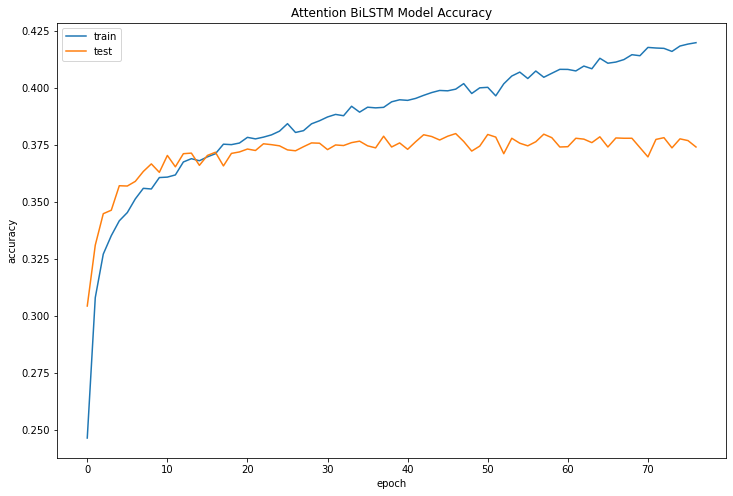

In [ ]:
# Accuracy plot for the model.
def plot_acc(history):
    fig = plt.figure(figsize=[12,8])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Attention BiLSTM Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.savefig('./figures/Bilstm_accuracy.png')
    plt.show()
    

plot_acc(history)


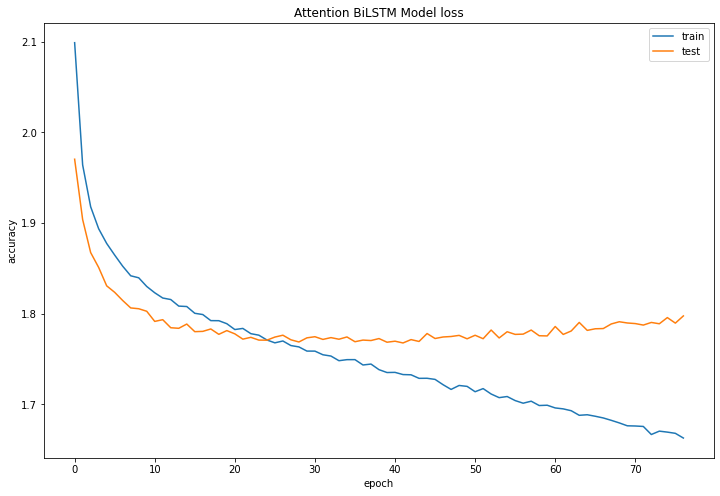

In [ ]:
# Loss plot for the Model.
def plot_loss(history):
    fig = plt.figure(figsize=[12,8])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Attention BiLSTM Model loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.savefig('./figures/Bilstm_loss.png')
    plt.show()

plot_loss(history)

In [ ]:
# prediction on test data for prediction Metrics
y_pred = model.predict(X_test)
#Y_test = np.argmax(y_test, axis=1) 
y_pred_class = np.argmax(y_pred, axis=1) 

## test Utilisation multinomial random pour le choix de la classe
# y_pred_class = np.array([np.random.multinomial(1, proba) for proba in y_pred])
# y_pred_class = np.argmax(y_pred_class, axis=1) 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Predicted probability variance distribution')

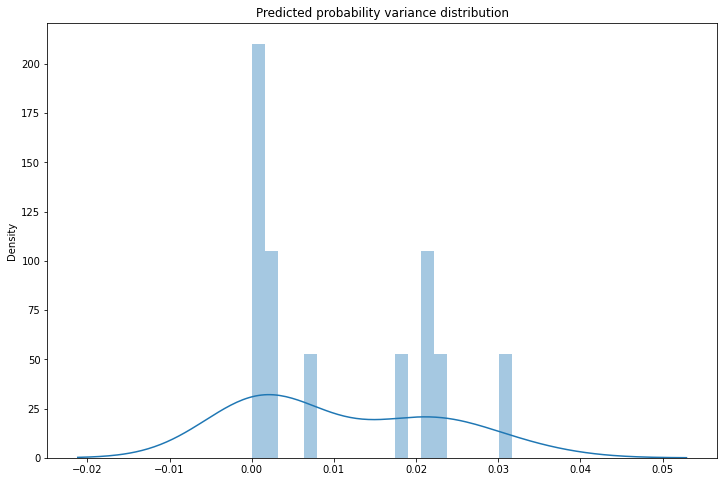

In [ ]:
variance_pred = np.var(y_pred, 0)

fig = plt.figure(figsize=[12,8])
sns.distplot(x = variance_pred, bins=20)
plt.title('Predicted probability variance distribution')

In [ ]:
# Classification report for the predicted results.

classes = list(labels.keys())
print(classification_report(y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

     sadness       0.37      0.25      0.30      1032
  enthusiasm       0.00      0.00      0.00       152
     neutral       0.38      0.62      0.47      1716
       worry       0.38      0.42      0.40      1691
    surprise       0.38      0.03      0.06       437
        love       0.53      0.42      0.47       768
         fun       0.15      0.02      0.03       355
        hate       0.42      0.31      0.36       265
   happiness       0.34      0.48      0.40      1042
     boredom       0.00      0.00      0.00        36
      relief       0.28      0.05      0.08       305
       anger       0.00      0.00      0.00        22

    accuracy                           0.38      7821
   macro avg       0.27      0.22      0.21      7821
weighted avg       0.36      0.38      0.35      7821



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


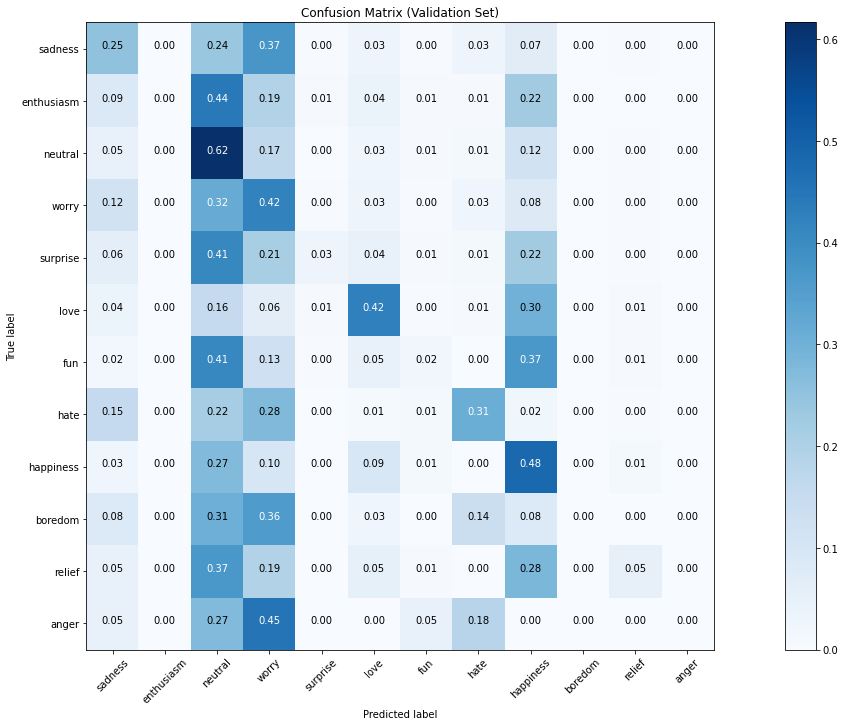

In [ ]:
# Confusion matrix for results visualistaion

cnf_matrix = confusion_matrix(y_test, y_pred_class)

def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./figures/conf_matrix.png')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)

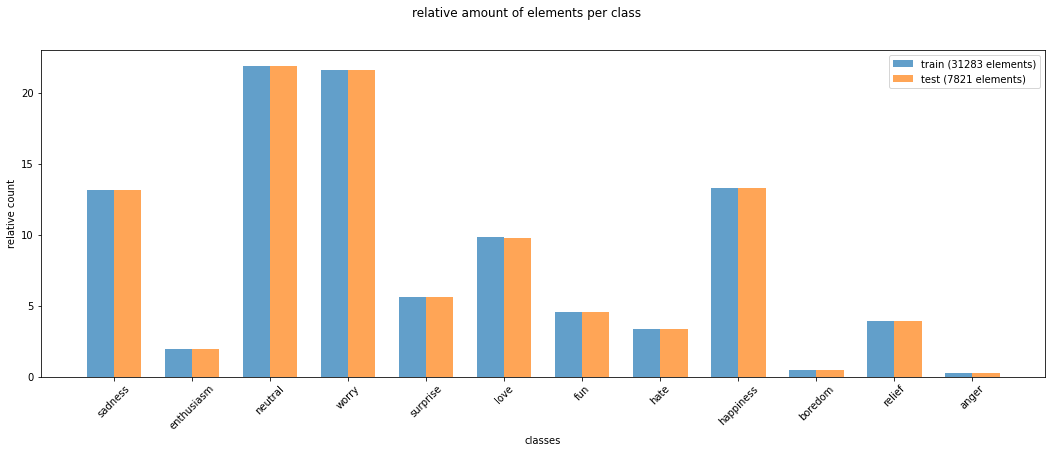

In [ ]:

plt.figure(figsize=(18,6))
plt.suptitle('relative amount of elements per class')
plot_hist(y_train, labels, loc='left')
plot_hist(y_test, labels, loc='right')
plt.legend(['train ({0} elements)'.format(len(y_train)), 'test ({0} elements)'.format(len(y_test))]);

In [ ]:
def missclass(y_pred, y_test):
    index = 0
    misclassifiedIndex = []
    for predict, actual in zip(y_pred, y_test):
        if predict != actual: 
            misclassifiedIndex.append(index)
        index +=1
    return misclassifiedIndex
misclassifiedIndex = missclass(y_pred_class, y_test)

In [ ]:
def print_missclass(cleaned_data, y_test, y_pred, misclassifiedIndex, nmin, nmax):
    print("PROBLEM WITH INDEX -> changer cleaned_data")
    for plotIndex, wrong in enumerate(misclassifiedIndex[nmin:nmax]):
        print(f"Actual : {inv_labels[y_test[wrong]]}, Predicted : {inv_labels[y_pred[wrong]]}")
        print(cleaned_data['content'][wrong])
        print("---"*15)

print_missclass(cleaned_data, y_test, y_pred_class, misclassifiedIndex, 1, 10)

PROBLEM WITH INDEX -> changer cleaned_data
Actual : enthusiasm, Predicted : worry
layin n bed with a headache ughhhh waitin on your call
---------------------------------------------
Actual : love, Predicted : neutral
funeral ceremony gloomy friday
---------------------------------------------
Actual : worry, Predicted : love
we want to trade with someone who has houston tickets but no one will
---------------------------------------------
Actual : worry, Predicted : happiness
charlene my love i miss you
---------------------------------------------
Actual : love, Predicted : neutral
i m sorry at least it s friday
---------------------------------------------
Actual : love, Predicted : happiness
choked on her retainers
---------------------------------------------
Actual : worry, Predicted : neutral
ugh i have to beat this stupid song to get to the next rude
---------------------------------------------
Actual : sadness, Predicted : worry
if u watch the hills in london u will realise w

In [ ]:
cleaned_data[cleaned_data['content']=='funeral ceremony gloomy friday']

,content,sentiment
2,funeral ceremony gloomy friday,sadness


In [ ]:
def predict_emo(sentence, model=model, inv_labels=inv_labels, stop_words=stop_words, \
                        SENTENCE_LENGTH=SENTENCE_LENGTH):
    print("sentence :", sentence)
    df = pd.DataFrame(np.array([sentence]), columns=['sentence'])
    pre_proceed = preprocess_data(df['sentence'])
    pre_proceed['sentence'] = pre_proceed['sentence'].apply(lambda x: [item for item in \
                                    x if item not in stop_words])
    print("pre_proceed sentence :", pre_proceed['sentence'])
    embedded_sentence = word_tokenizer.texts_to_sequences(pre_proceed)
    pad_sentence = pad_sequences(embedded_sentence, SENTENCE_LENGTH, padding='post')
    pred = model.predict(pad_sentence)
    pred_class = np.argmax(pred, axis=1)
    print("prediction : ", inv_labels[pred_class[0]])
    return inv_labels[pred_class[0]]

In [ ]:
# text = 'you would not unfollow me would you then i would cry'
text = 'I am very happy'
emo = predict_emo(text)

sentence : I am very happy
pre_proceed sentence : 0    [happy]
Name: sentence, dtype: object
prediction :  neutral


## Explaining predictions using lime

In [ ]:
from lime import lime_text
import lime

ModuleNotFoundError: ignored

In [ ]:
class_names = [k for k,v in labels.items()]
class_names

NameError: ignored

In [ ]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

ModuleNotFoundError: ignored

In [ ]:
def predict_proba(sentence, model=model, inv_labels=inv_labels, stop_words=stop_words, \
                        SENTENCE_LENGTH=SENTENCE_LENGTH):
    print("sentence :", sentence)
    df = pd.DataFrame(np.array([sentence]), columns=['sentence'])
    pre_proceed = preprocess_data(df['sentence'])
    pre_proceed['sentence'] = pre_proceed['sentence'].apply(lambda x: [item for item in \
                                    x if item not in stop_words])
    print("pre_proceed sentence :", pre_proceed['sentence'])
    embedded_sentence = word_tokenizer.texts_to_sequences(pre_proceed)
    pad_sentence = pad_sequences(embedded_sentence, SENTENCE_LENGTH, padding='post')
    pred = model.predict(pad_sentence)
    return pred[0]

NameError: ignored

In [ ]:
idx = 7
exp = explainer.explain_instance([cleaned_data['content'][idx]], predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Predicted class =', class_names[np.argmax(model.predict(np.array([X_test[idx,:]])), axis=1)\
                                       .reshape(1,-1)[0,0]])
print('True class: %s' % class_names[y_test[idx]])

NameError: ignored

# grid search

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
def create_model(vocab_length, embedding_matrix, SENTENCE_LENGTH, trainable=True, drop_percent=0.3, \
                        hidden=1, opt=tf.keras.optimizers.Adadelta(learning_rate=0.5), np_LSTM = 32, np_hidden=32):
    
    # Define the model for learning (Attention - Bidirectional LTSM)
    model = Sequential()
    model.add(layers.Embedding(vocab_length, 
                              embedding_dim,
                              weights=[embedding_matrix],
                              input_length=SENTENCE_LENGTH, 
                              trainable=trainable))
    model.add(layers.Dropout(drop_percent))
    model.add(layers.Bidirectional(
        layers.LSTM(np_LSTM, dropout=drop_percent, 
                    kernel_regularizer=tf.keras.regularizers.l2(1e-5), 
                    return_sequences=True)))
    model.add(attention(return_sequences=False))
    model.add(layers.Dropout(drop_percent))
    if hidden!=0:
        for i in range():
            model.add(layers.Dense(np_hidden, activation = 'elu'))
            model.add(layers.Dropout(drop_percent))
    model.add(layers.Dense(n_class, activation = 'softmax'))

    ## compile
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])# optimizer opt
    return model

In [ ]:
opt1 = tf.keras.optimizers.Adadelta(learning_rate=1.0)
opt2 = tf.keras.optimizers.Adadelta(learning_rate=0.1)
opt3 = tf.keras.optimizers.Adadelta(learning_rate=5e-2)
param_grid = dict(np_LSTM=[32, 64, 128],
                  np_hidden=[32, 64, 128],
                  hidden=[1, 2, 3, 4],
                  #opt=['adam', opt1, opt2, opt3],
                  drop_percent = [0.1, 0.2, 0.3, 0.4],
                  vocab_length = [vocab_length],
                  embedding_matrix = [embedding_matrix],
                  SENTENCE_LENGTH = [SENTENCE_LENGTH]
                  )


In [ ]:
clear_session()

batch_size=128, 
epochs=230,
model = KerasClassifier(build_fn=create_model,
                        epochs=epochs, 
                        batch_size=batch_size,
                        use_multiprocessing=True,
                        verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                          cv=4, verbose=3)
# grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
#                               cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train,
                    callbacks=[early_stopping])#, validation_data=(X_test, y_test))

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)


Fitting 4 folds for each of 36 candidates, totalling 144 fits
[CV] SENTENCE_LENGTH=19, drop_percent=0.1, embedding_matrix=[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.15967999 -0.36965999  0.23761    ...  0.14169    -0.13463999
  -0.602     ]
 [ 0.26750001  0.77982002 -0.87296999 ...  0.77863997 -0.35301
   1.02509999]
 ...
 [-0.68624002 -0.64551997  0.10681    ... -0.096969   -0.43715
   0.0014255 ]
 [-0.54018003 -0.33388001 -0.15349001 ...  0.046026   -0.075047
   0.47051001]
 [ 0.37977001  0.037007    0.093277   ... -0.42454001  0.27476999
  -0.18692   ]], np_LSTM=32, np_hidden=32, vocab_length=22872 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: unsupported operand type(s) for -: 'tuple' and 'int'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  SENTENCE_LENGTH=19, drop_percent=0.1, embedding_matrix=[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.15967999 -0.36965999  0.23761    ...  0.14169    -0.13463999
  -0.602     ]
 [ 0.26750001  0.77982002 -0.87296999 ...  0.77863997 -0.35301
   1.02509999]
 ...
 [-0.68624002 -0.64551997  0.10681    ... -0.096969   -0.43715
   0.0014255 ]
 [-0.54018003 -0.33388001 -0.15349001 ...  0.046026   -0.075047
   0.47051001]
 [ 0.37977001  0.037007    0.093277   ... -0.42454001  0.27476999
  -0.18692   ]], np_LSTM=32, np_hidden=32, vocab_length=22872, score=nan, total=   0.7s
[CV] SENTENCE_LENGTH=19, drop_percent=0.1, embedding_matrix=[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.15967999 -0.36965999  0.23761    ...  0.14169    -0.13463999
  -0.602     ]
 [ 0.26750001  0.77982002 -0.87296999 ...  0.77863997 -0.35301
   1.02509999]
 ...
 [-0.68624002 -0.64551997  0.10681    ... -0.096969   -0.43715
   0.0014255 ]
 [-0.54018003 -0

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  SENTENCE_LENGTH=19, drop_percent=0.1, embedding_matrix=[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.15967999 -0.36965999  0.23761    ...  0.14169    -0.13463999
  -0.602     ]
 [ 0.26750001  0.77982002 -0.87296999 ...  0.77863997 -0.35301
   1.02509999]
 ...
 [-0.68624002 -0.64551997  0.10681    ... -0.096969   -0.43715
   0.0014255 ]
 [-0.54018003 -0.33388001 -0.15349001 ...  0.046026   -0.075047
   0.47051001]
 [ 0.37977001  0.037007    0.093277   ... -0.42454001  0.27476999
  -0.18692   ]], np_LSTM=32, np_hidden=32, vocab_length=22872, score=nan, total=   0.7s
[CV] SENTENCE_LENGTH=19, drop_percent=0.1, embedding_matrix=[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.15967999 -0.36965999  0.23761    ...  0.14169    -0.13463999
  -0.602     ]
 [ 0.26750001  0.77982002 -0.87296999 ...  0.77863997 -0.35301
   1.02509999]
 ...
 [-0.68624002 -0.64551997  0.10681    ... -0.096969   -0.43715
   0.0014255 ]
 [-0.54018003 -0

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  1.7min finished


RuntimeError: ignored

In [ ]:
# prediction on test data for prediction Metrics
y_pred = grid.predict(X_test)
#Y_test = np.argmax(y_test, axis=1) 
y_pred_class = np.argmax(y_pred, axis=1) 

In [ ]:
plot_loss(grid_result)
plot_acc(grid_result)

In [ ]:
# Confusion matrix for results visualistaion

cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)